# Introduction to PCA

Part 1: PCA in pure NumPy

Part 2: sklearn's version of PCA

## Setup

In [1]:
# imports and setup
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('precision', 4) # number precision for pandas
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 12)
pd.set_option('display.float_format', '{:20,.5f}'.format) # get rid of scientific notation

import seaborn as sns
plt.style.use('seaborn') # pretty matplotlib plots

sns.set(style='whitegrid', context='notebook', font_scale=np.sqrt(2))

In [2]:
def new_fig_with_equal_aspect_ratio():
    ax = plt.gca()
    ax.set_aspect('equal');
    return ax

In [3]:
def set_equal_limits(ax, min_val=-2.0, max_val=2.0):
    ax.set_xlim([min_val, max_val]); 
    ax.set_ylim([min_val, max_val]);
    ax.set_xlabel('x1');
    ax.set_ylabel('x2');
    ticks = ax.get_xticks();
    labels = ax.get_xticklabels();
    ax.set_xticks(ticks); ax.set_yticks(ticks);
    ax.set_xticklabels(ticks);
    ax.set_yticklabels(ticks);

# PART 1: PCA in Pure Numpy

### Create simple toy dataset in 2D

In [4]:
x = np.random.randn(100)
y = 1.0 * x + 0.2 * np.random.randn(100)

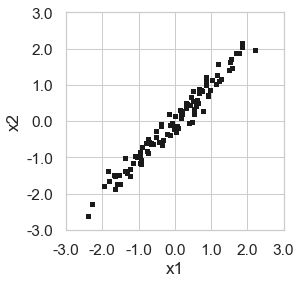

In [5]:
ax = new_fig_with_equal_aspect_ratio()
ax.plot(x, y, 'ks', ms=5);
set_equal_limits(ax, -3, +3);

## Summarize toy dataset

In [6]:
x_NF = np.hstack([x[:,np.newaxis], y[:,np.newaxis]])
N = x_NF.shape[0]

print(x_NF.shape)

(100, 2)


# Step-by-step approach to applying PCA

In [7]:
# Zero-center the data
mu_F = np.mean(x_NF, axis=0)
xc_NF = x_NF - mu_F[np.newaxis,:]

In [8]:
# Compute covariance matrix
cov_FF = np.dot(xc_NF.T, xc_NF) / N
cov2_FF = np.cov(x_NF.T, bias=1)
assert np.allclose(cov_FF, cov2_FF)

In [9]:
# Find eigenvalues/vectors
eig_vals_F, v_FF = np.linalg.eig(cov_FF)
print("shape of eig_vals_F: %s" % eig_vals_F.shape)
print("shape of v_FF: %s" % str(v_FF.shape))


shape of eig_vals_F: 2
shape of v_FF: (2, 2)


In [10]:
# Select top K eigenvectors
K = 1

In [11]:
sort_ids_F = np.argsort(eig_vals_F)[::-1] # sort eigenvalues largest to smallest
sort_ids_K = sort_ids_F[:K]

eig_vals_K = eig_vals_F[sort_ids_K]
v_FK = v_FF[:, sort_ids_K]

In [12]:
eig_vals_K

array([2.26522862])

In [13]:
print("First principal component:")
print(v_FK)

print("Double check: is this a unit vector?")
print("L2 norm: %.3f" % np.sqrt(np.sum(np.square(v_FK), axis=0)))

First principal component:
[[-0.70160111]
 [-0.71256991]]
Double check: is this a unit vector?
L2 norm: 1.000


# Show the first eigen vector along with data

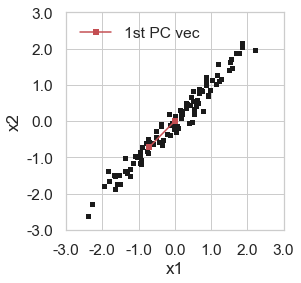

In [14]:
ax = new_fig_with_equal_aspect_ratio()
ax.plot(x_NF[:,0], x_NF[:,1], 'ks', ms=5);
ax.plot([0,v_FK[0]], [0,v_FK[1]], 'rs-', label='1st PC vec');
set_equal_limits(ax, -3, +3);
ax.legend();

# PCA: Each step wrapped in a function

In [15]:
def calculate_pca(x_NF, K=1):
    mu_F = np.mean(x_NF, axis=0)

    # Zero-center the data
    xc_NF = x_NF - mu_F[np.newaxis,:]

    # Compute covariance matrix of centered data
    cov_FF = np.dot(xc_NF.T, xc_NF) / N

    eig_vals_F, v_FF = np.linalg.eig(cov_FF) # Find eigenvalues/vectors: can be slow!
    sort_ids_F = np.argsort(eig_vals_F)[::-1] # sort eigenvalues largest to smallest
    sort_ids_K = sort_ids_F[:K]

    eig_vals_K = eig_vals_F[sort_ids_K]
    v_FK = v_FF[:, sort_ids_K]
    return eig_vals_K, v_FK, mu_F

# Project: From 2D to 1D

In [16]:
def project(x_NF, mu_F, eig_vals_K, v_FK):
    xc_NF = x_NF - mu_F[np.newaxis,:]
    return np.dot(xc_NF, v_FK) * 1.0 / np.sqrt(eig_vals_K)[np.newaxis,:]


# Reconstruct: From 1D to 2D

In [17]:
def reconstruct(z_NK, mu_F, eig_vals_K, v_FK):
    return mu_F[np.newaxis,:] + np.dot(z_NK, np.sqrt(eig_vals_K)[:,np.newaxis] * v_FK.T)

# Show reconstructions with non-centered 2D toy data

In [18]:
random_state = np.random.RandomState(0)
x1 = -2.0 + random_state.randn(100)
x2 = 1.0 * x1 + 0.5 * random_state.randn(100)
x_NF = np.hstack([x1[:,np.newaxis], x2[:,np.newaxis]])

In [19]:
eig_vals_K, v_FK, mu_F = calculate_pca(x_NF, 1)

In [20]:
z_NK = project(x_NF, mu_F, eig_vals_K, v_FK)

In [21]:
print("mean of z: % .3f" % (np.mean(z_NK)))
print("var  of z: % .3f" % (np.var(z_NK)))

mean of z: -0.000
var  of z:  1.000


In [22]:
x2_NF = reconstruct(z_NK, mu_F, eig_vals_K, v_FK)

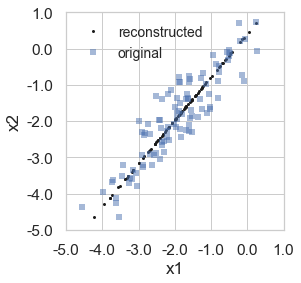

In [23]:
ax = new_fig_with_equal_aspect_ratio()
ax.plot(x2_NF[:,0], x2_NF[:,1], 'k.', label='reconstructed')
ax.plot(x_NF[:,0], x_NF[:,1], 'bs', alpha=0.5, label='original')
ax.legend(fontsize=14);
set_equal_limits(ax, -5, 1)

# PART 2: Try on same dataset with sklearn

In [24]:
from sklearn.decomposition import PCA

pca1 = PCA(n_components=1)
pca2 = PCA(n_components=2)

In [25]:
pca1.fit(x_NF);
pca2.fit(x_NF);

### Show the eigenvalues ('explained_variances_') 

In [26]:
pca2.explained_variance_

array([2.32224512, 0.11795782])

In [27]:
eig_vals_K

array([2.29902267])

### Show the eigenvectors ('components_')

In [28]:
pca2.components_

array([[-0.64185929, -0.76682243],
       [-0.76682243,  0.64185929]])

In [29]:
v_FK.T

array([[-0.64185929, -0.76682243]])

# Reconstruction using 1 PC only

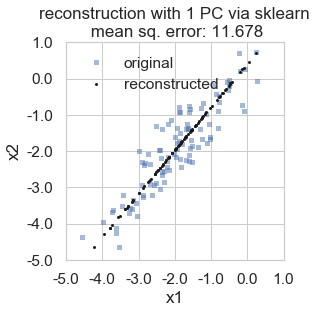

In [30]:
x2_NF = pca1.inverse_transform(pca1.transform(x_NF))

ax = new_fig_with_equal_aspect_ratio()
ax.plot(x_NF[:,0], x_NF[:,1], 'bs', alpha=0.5, ms=5, label='original')
ax.plot(x2_NF[:,0], x2_NF[:,1], 'k.', label='reconstructed')
ax.legend();
ax.set_title('reconstruction with 1 PC via sklearn\n mean sq. error: %.3f' % (
    np.mean(np.sum(np.square(x_NF - x2_NF)))))
set_equal_limits(ax, -5, 1)

# Reconstruction using 2 PCs

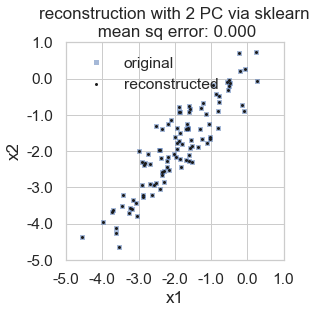

In [31]:
x2_NF = pca2.inverse_transform(pca2.transform(x_NF))

ax = new_fig_with_equal_aspect_ratio()
ax.plot(x_NF[:,0], x_NF[:,1], 'bs', alpha=0.5, ms=5, label='original')
ax.plot(x2_NF[:,0], x2_NF[:,1], 'k.', label='reconstructed')
ax.legend();
ax.set_title('reconstruction with 2 PC via sklearn\n mean sq error: %.3f' % (
    np.mean(np.sum(np.square(x_NF - x2_NF)))))
set_equal_limits(ax, -5, 1)

## Properties of the default sklearn embedding features?

Looks like the sklearn default doesn't transform the z-space features to have unit variance

In [32]:
z_sklearn_NK = pca2.transform(x_NF)

In [33]:
np.var(z_sklearn_NK, axis=0)

array([2.29902267, 0.11677824])

In [34]:
pca2.explained_variance_

array([2.32224512, 0.11795782])

In [35]:
pca2.explained_variance_ * (N-1) / N

array([2.29902267, 0.11677824])